In [2]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

In [3]:
stock_price = pd.read_csv("../dataset/stock_price_data/Pfizer_data.csv")

In [4]:
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-10-01,35.930000,36.020000,35.430000,35.430000,34.060383,20885200
1,2019-10-02,35.259998,35.270000,34.660000,34.700001,33.358604,21307400
2,2019-10-03,34.709999,35.470001,34.599998,35.450001,34.079609,20945100
3,2019-10-04,35.490002,35.980000,35.450001,35.930000,34.541054,17139800
4,2019-10-07,35.820000,36.259998,35.799999,35.830002,34.444920,11156900


In [5]:
pfizer_close = stock_price['Close']
n = 7
moving_avg = [sum(pfizer_close[i-n:i])/n for i in range(n, len(pfizer_close))]
moving_stdev = (pfizer_close[n:] - moving_avg)**2

m = 3
moving_stdev_smooth = [sum(moving_stdev[i-m:i])/m for i in range(m,len(moving_stdev))]

dates = pd.to_datetime(stock_price["Date"], format = '%Y-%m-%d')[n+m:]
dates.head()


10   2019-10-15
11   2019-10-16
12   2019-10-17
13   2019-10-18
14   2019-10-21
Name: Date, dtype: datetime64[ns]

/Users/suraj/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


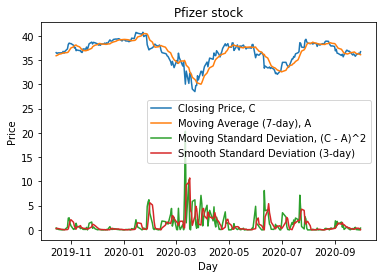

In [6]:
plt.plot(dates, pfizer_close[n+m:], label="Closing Price, C")
plt.plot(dates, moving_avg[m:], label=f"Moving Average ({n}-day), A")
plt.plot(dates, moving_stdev[m:], label="Moving Standard Deviation, (C - A)^2")
plt.plot(dates, moving_stdev_smooth, label=f"Smooth Standard Deviation ({m}-day)")
plt.title("Pfizer stock")
plt.legend()
plt.xlabel("Day")
plt.ylabel("Price")
plt.rcParams["figure.figsize"]=(15,5) # (width, height)
plt.show()

In [96]:
djia = pd.read_csv("../dataset/stock_price_data/DJIA_data.csv")
djia_data = djia['Close']
relative_price = (djia_data[m+n:]/pfizer_close[m+n:])/10
mean_diff1 = np.array([(pfizer_close[i-n:i] - (sum(pfizer_close[i-n:i])/n)) for i in range(n, len(pfizer_close))])
mean_diff2 = np.array([(djia_data[i-n:i] - (sum(djia_data[i-n:i])/n)) for i in range(n, len(djia_data))])
mean_diff_prod = mean_diff1[:-1].T * mean_diff2.T
moving_sum = np.array([sum(mean_diff_prod[i-n:i]) for i in range(n, len(mean_diff_prod))])

np_cov = np.array([np.cov(pfizer_close[i-n:i], djia_data[i-n:i])[0,1]/n for i in range(n, len(pfizer_close))])
np_cov[:10]

array([ 8.55815209, 10.06921841,  7.8708289 ,  9.06876468, 15.66138484,
       18.28670974, 12.01353324,  5.77208672,  0.86027143,  0.26852954])

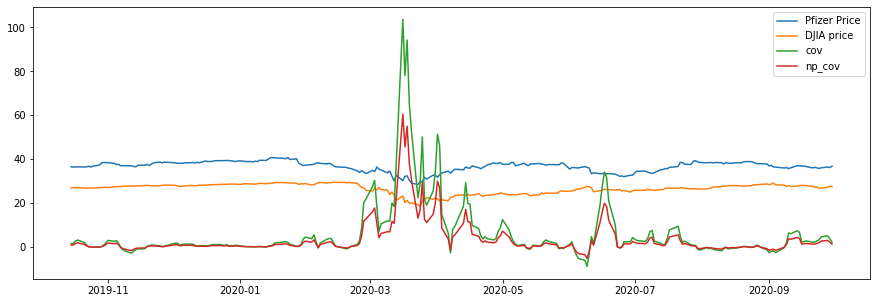

In [100]:
# plt.clear()
# plt.plot(dates, relative_price, label="Relative Price")
plt.plot(dates, pfizer_close[n+m:], label="Pfizer Price")
plt.plot(dates, djia_data[m+n-1:]/1000, label="DJIA price")
plt.plot(dates, cov[2:], label='cov')
plt.plot(dates, np_cov[2:-1]/10, label='np_cov')
plt.legend()
plt.show()